## <a id='toc1_1_'></a>[ARIMA model for predictions and some technical analysis tools](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [ARIMA model for predictions and some technical analysis tools](#toc1_1_)    
    - [ARIMA model](#toc1_1_1_)    
    - [Technical analysis tools](#toc1_1_2_)    
      - [Bollinger bands](#toc1_1_2_1_)    
      - [Keltner channels](#toc1_1_2_2_)    
      - [MACD](#toc1_1_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[ARIMA model](#toc0_)

In [2]:
import yfinance as yf
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
today = dt.datetime.today()
YTD = (dt.datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')
bday = 0

while bday < 1:
    today += dt.timedelta(days=1)
    if today.weekday() <= 5:
        bday += 1
today = today.strftime('%Y-%m-%d')

In [4]:
data = yf.download('PUB.PA', start=YTD, end=today)

X = np.array(data['Adj Close'].to_list())
X = X[~np.isnan(X)]

hp = np.array(data.High.to_list())
hp = hp[~np.isnan(hp)]

lp = np.array(data.Low.to_list())
lp = lp[~np.isnan(lp)]

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'PUB.PA')

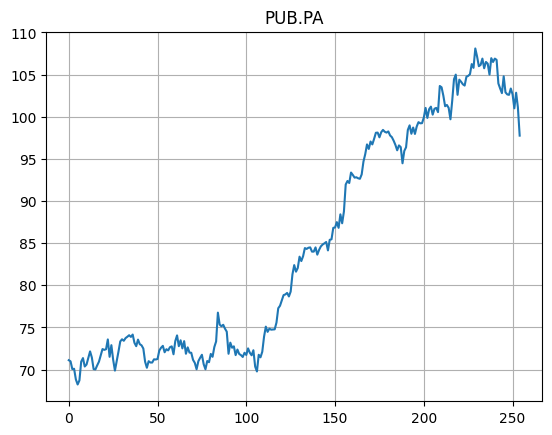

In [28]:
plt.plot(X)
plt.grid()
plt.title('PUB.PA')

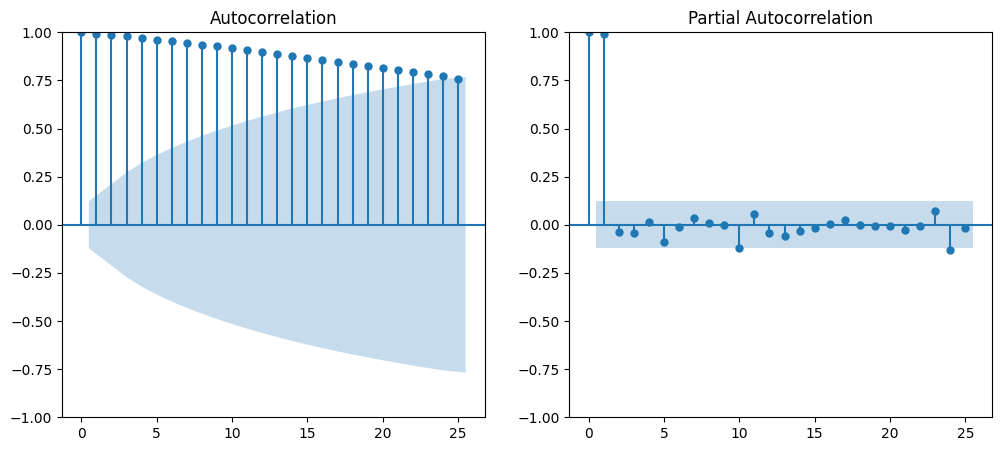

In [29]:
_, axs = plt.subplots(1,2, figsize=(12,5))
plot_acf(X, ax=axs[0])
plot_pacf(X, ax=axs[1])
plt.show()

Data seems non stationary, we can confirm this result with the augmented Dickey-Fuller test

In [30]:
adfuller_res = adfuller(X)
print(f'p-value : {adfuller_res[1]}')

p-value : 0.8766594762189012


For a 95% confidence interval, p-value > 0.05%. Hence, we cannot reject null hypothesis in which the process is non stationary. Let's try differencing time series to stationarize data. We first take a differenciation order $d=1$ :
$$
    \widehat{y}_i = y_i - y_{i-1}
$$

In [31]:
statio_X = pd.Series(X).diff(1)
statio_X.dropna(axis=0, inplace=True)
adfuller_res = adfuller(statio_X)

print(f'p-value : {adfuller_res[1]}')

p-value : 5.3261118554254406e-30


Time series can now be considered stationary.

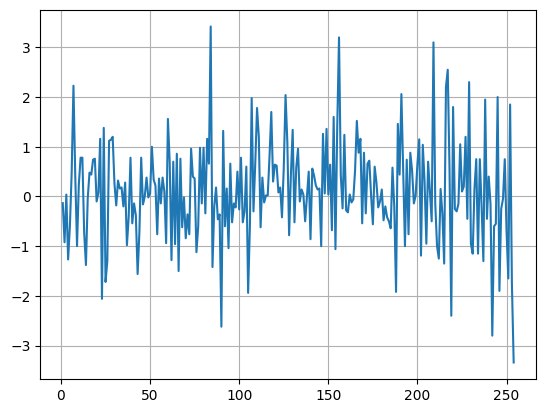

In [32]:
plt.plot(statio_X)
plt.grid()

Before fitting our ARIMA model, to test our model, we split our historical data in two parts :
- a training set to train our model
- a test set to compare predictions to reality

In [33]:
X = pd.Series(X)

train_prop = 0.7 # train set represents 70% of global data set
limit = int(len(X)*train_prop)
train = X[:limit]
test = X[limit:]

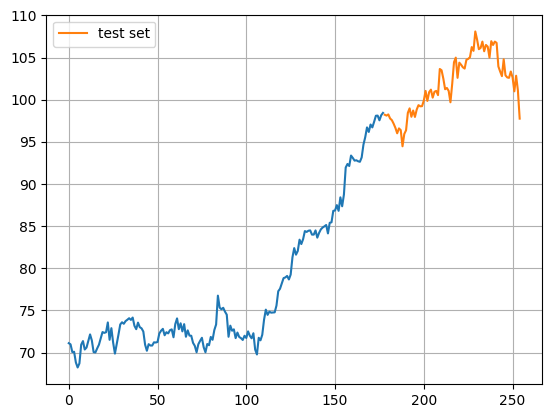

In [34]:
train.plot()
test.plot(label='test set')
plt.grid()
plt.legend()

We now use pmdarima to perform automatic arima fitting for parameters. It will stationarize data as we did above, by differencing data. It will also select p and q (resp. number of lags for Auto Regressive part and number of lags for Moving Average part). Finally, it will deal with seasonality. Indeed, we can decompose our time series in three parts :
- Trend
- Seasonality
- Residuals

Here, we will choose monthly seasonality :

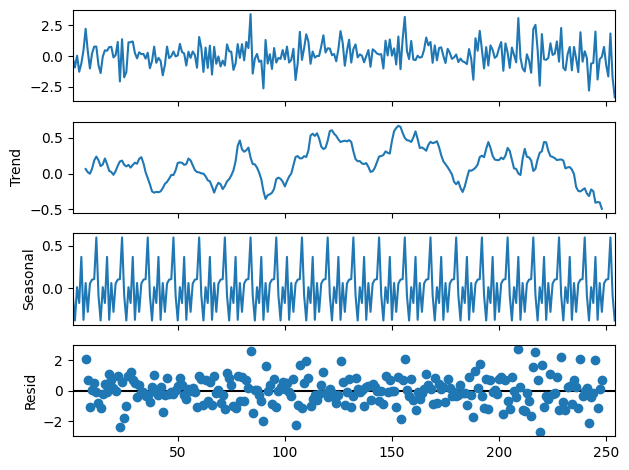

In [35]:
decomp = seasonal_decompose(statio_X, model='additive', period=12)
decomp.plot()
plt.show()

<b>Note :</b><br>
ARIMA model refers to 'Auto Regressive Moving Average' with integration for stationarity.<br>
MA Model is of the form :
$$
    X_t = \mu + \sum_{i=1}^q\theta_i\xi_{t-i} + \xi_t
$$
where $\mu$ is a constant, $\xi$ are residual terms, usually white noises.<br>
AR is of the form :
$$
    X_t = \nu + \sum_{i=1}^p\varphi_i X_{t-i} + \xi_t
$$
where $\nu$ is a constant, $\xi$ a residual, usually a white noise.<br>
Hence we need to fit $(\theta_i)_{1\leq i\leq q}$, $(\varphi_i)_{1\leq i\leq p}$ on our data.

Removing the seasonal component is an essential step before fitting ARIMA model. pmdarima will fit p and q parameters in order to minimize HQIC Information Criterion.
$$
    \text{HQIC} = -2\times\text{log-likelihood} +2k\log(\log(n))
$$
where $n$ is the size of the data set, $k$ the number of parameters.

In [36]:
import pmdarima

arima = pmdarima.auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_p=500,
                            max_q=500,
                            information_criterion='hqic',
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            scoring='mse')

Performing stepwise search to minimize hqic
 ARIMA(1,2,1)(0,0,0)[0]             : HQIC=471.748, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : HQIC=600.713, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : HQIC=539.866, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : HQIC=470.539, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : HQIC=471.744, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : HQIC=475.190, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : HQIC=inf, Time=0.17 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.534 seconds


In [37]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -231.983
Date:                Sun, 16 Jun 2024   AIC                            467.967
Time:                        21:58:02   BIC                            474.308
Sample:                             0   HQIC                           470.539
                                - 178                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9765      0.025    -39.118      0.000      -1.025      -0.928
sigma2         0.8032      0.067     11.907      0.000       0.671       0.935
===================================================================================
Ljung-Box (L1) (Q):                   2.59   Jarque-Bera (JB):                12.67
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.26
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

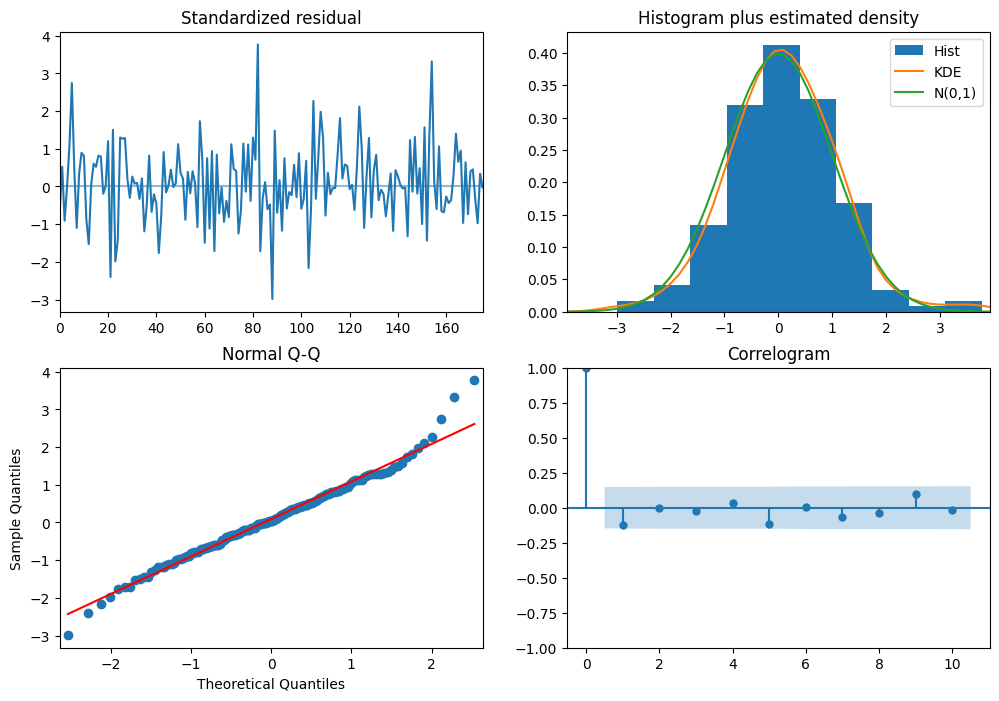

In [38]:
arima.plot_diagnostics(figsize=(12,8))
plt.show()

Here diagnostic shows that (in the QQ plot) our residuals are almost distributed like a standard gaussian density, but correlogram show that there are still significant information within residuals, which can be a problem. Let's do a check on test set to see if model fits well data. To do so, we use a step-wise approach.

In [45]:
prediction = []
confints = []
for el in test:
    pred, confint = arima.predict(n_periods=1, return_conf_int=True)
    if type(pred) == list or type(pred) == np.ndarray:
        prediction.append(pred[0])
    else:
        prediction.append(pred)
    confints.append(confint[0])
    arima.update(el)

In [46]:
predicted = pd.DataFrame(prediction, index=test.index, columns=['pred'])
l_conf = [x[0] for x in confints]
u_conf = [x[1] for x in confints]

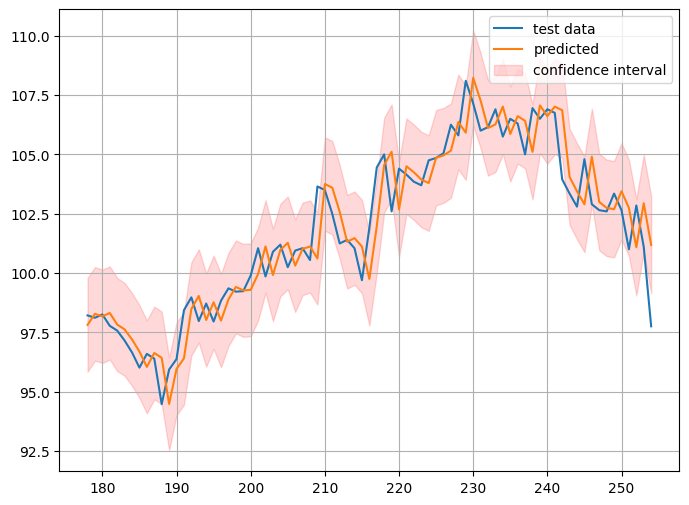

In [47]:
_, ax = plt.subplots(figsize=(8,6))
ax.plot(test.index, test, label='test data')
ax.plot(test.index, predicted, label='predicted')
ax.fill_between(test.index, l_conf, u_conf, color='red', alpha=0.15, label='confidence interval')
ax.grid()
ax.legend()

Predictions suggest that the model predicts well data. We can confirm that with MAE (Mean absolute error) to see mean error produced by the model.
$$
    \text{MAE} = \dfrac{1}{N}\sum_{i=1}^N | y_i - \widehat{y}_i |
$$

In [42]:
np.mean(np.abs(np.array(predicted.pred.to_list()) - np.array(test.to_list())))

0.9364002181605573

Mean error is approximately 0.93€, which is acceptable.

### <a id='toc1_1_2_'></a>[Technical analysis tools](#toc0_)

We will focus on three different technical indicators :
- Bollinger bands
- Keltner channels
- MACD (Moving Average Convergence Divergence)

In [160]:
def plot_bollinger_bands(values, middle_window_size=20, quantity_std=2):
    std = pd.Series(values).rolling(window=middle_window_size).std()
    middle_line = pd.Series(values).rolling(window=middle_window_size).mean()
    upper_line = middle_line + quantity_std*std
    lower_line = middle_line - quantity_std*std

    x = [i for i in range(len(middle_line))]

    plt.plot(x, values)
    plt.plot(x, middle_line, label='middle', lw=1)
    plt.plot(x, lower_line, color='red', lw=1, linestyle='--')
    plt.plot(x, upper_line, color='green', lw=1, linestyle='--')
    plt.fill_between(x, lower_line, upper_line, color='grey', alpha=0.2)
    plt.title('Bollinger bands')
    plt.grid()
    plt.legend()

def plot_keltner_channels(hp, lp, values, middle_window_size=14, atr_mult=2):
    df = pd.DataFrame(columns=['HL', 'H_PREV', 'L_PREV', 'TR'])
    values_series = pd.Series(values)
    ma = values_series.ewm(span=middle_window_size, adjust=False).mean()

    df['HL'] = hp - lp
    df['H_PREV'] = np.abs(hp - values_series.shift(1))
    df['L_PREV'] = np.abs(lp - values_series.shift(1))
    df['TR'] = df[['HL', 'H_PREV', 'L_PREV']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=middle_window_size).mean()

    upper, lower = ma + atr_mult*df['ATR'], ma - atr_mult*df['ATR']
    x = [i for i in range(len(ma))]


    plt.plot(x, values)
    plt.plot(x, ma, label='middle', lw=1)
    plt.plot(x, lower, color='red', lw=1, linestyle='--')
    plt.plot(x, upper, color='green', lw=1, linestyle='--')
    plt.fill_between(x, lower, upper, color='grey', alpha=0.2)
    plt.title('Keltner channels')
    plt.grid()
    plt.legend()

def plot_macd(values, with_stock=False, ax=None):
    data = pd.Series(values)
    short_ma = data.ewm(span=12, adjust=False).mean()
    long_ma = data.ewm(span=26, adjust=False).mean()

    macd_line = short_ma - long_ma
    signal = macd_line.ewm(span=9, adjust=False).mean()
    hist = macd_line - signal
    positive_hist = np.maximum(hist, 0)
    negative_hist = np.minimum(hist, 0)

    x = [i for i in range(len(macd_line))]
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, macd_line, label='MACD')
    ax.plot(x, signal, label='Signal')
    ax.fill_between(x, macd_line, signal, color='grey', alpha=0.2)

    ax.bar(x, positive_hist, color='green')
    ax.bar(x, negative_hist, color='red')
    ax.set_title('MACD')
    ax.grid()
    ax.legend()

    if with_stock:
        ax2 = ax.twinx()
        ax2.plot(x, data, color='black')

#### <a id='toc1_1_2_1_'></a>[Bollinger bands](#toc0_)

Bollinger bands define three lines :
- A moving average of the price with, typically, a window size of 20 period (here, 20 days) that shows the trend of the price
- An upper bound which is the current value of the moving average plus a quantity of the rolling standard deviation computed on the same window size as the moving average
- A lower bound which is the current value of the moving average minus a quantity of the rolling standard deviation computed on the same window size as the moving average

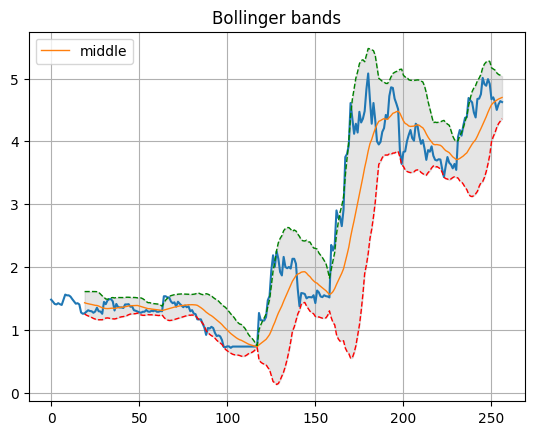

In [132]:
plot_bollinger_bands(X)

When the price hit the upper bound, it indicates that the asset may be overbought. When the price hit the lower bound, it indicates that the asset may be oversold. When the price repeatedly hit one of the bound, then hit the opposit bound, it may indicate a change in the trend (for instance, from downward to upward). Besides, the width of the bands shows how much variations are produced on the asset price : large bands width indicates large changes in asset's price.

#### <a id='toc1_1_2_2_'></a>[Keltner channels](#toc0_)

It relies on the same methodology. But here, upper and lower bounds are computed with ATR (Average True Range) which is a technical indicator of the volaility of the prices. ATR is computed using High Price, Low Price and Previous Closing Price.

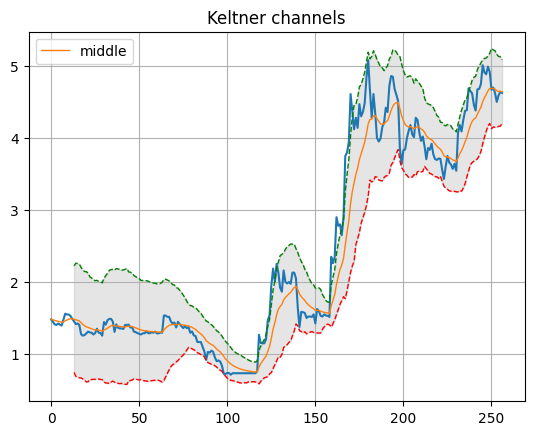

In [143]:
plot_keltner_channels(hp, lp, X)

#### <a id='toc1_1_2_3_'></a>[MACD](#toc0_)

MACD indicator is used to detect changes in trend. It relies on two lines :
- MACD line
- Signal line

MACD line is the difference between an exponential small window moving average (here 12 days) and an exponential large window moving average (here 26 days). Signal line is simply an exponential moving average with window size of 9 days. When signal line is below MACD difference signal, it indicates an upward trend. Conversely, when signal line is above MACD difference line, it indicates a downward trend.

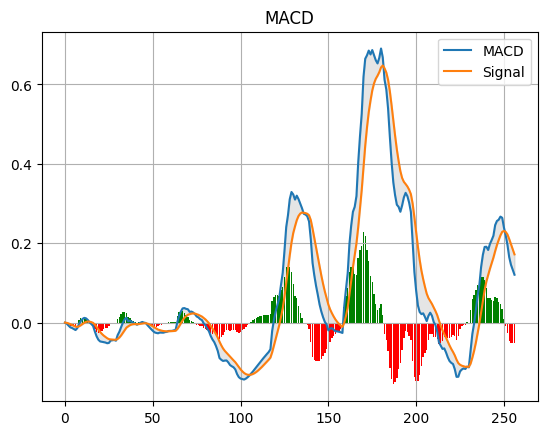

In [161]:
plot_macd(X)